# Sensor Modeling

This tutorial demonstrates how to model sensor geometries.

# Setup

In [1]:
import sys

# ! {sys.executable} -m pip install --quiet LibraryCorePy
# ! {sys.executable} -m pip install --quiet LibraryMathematicsPy
# ! {sys.executable} -m pip install --quiet LibraryPhysicsPy
# ! {sys.executable} -m pip install --quiet LibraryAstrodynamicsPy

In [238]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio

init_notebook_mode(connected=True)

In [239]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [240]:
Object2 = Mathematics.Geometry.D2.Object
Point2 = Mathematics.Geometry.D2.Objects.Point
LineString2 = Mathematics.Geometry.D2.Objects.LineString
Polygon2 = Mathematics.Geometry.D2.Objects.Polygon
Point3 = Mathematics.Geometry.D3.Objects.Point
Polygon3 = Mathematics.Geometry.D3.Objects.Polygon
Ellipsoid = Mathematics.Geometry.D3.Objects.Ellipsoid
Pyramid = Mathematics.Geometry.D3.Objects.Pyramid
Cone = Mathematics.Geometry.D3.Objects.Cone
Quaternion = Mathematics.Geometry.D3.Transformations.Rotations.Quaternion
RotationVector = Mathematics.Geometry.D3.Transformations.Rotations.RotationVector
RotationMatrix = Mathematics.Geometry.D3.Transformations.Rotations.RotationMatrix

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
AER = Physics.Coordinate.Spherical.AER
Position = Physics.Coordinate.Position
Velocity = Physics.Coordinate.Velocity
Frame = Physics.Coordinate.Frame
Transform = Physics.Coordinate.Transform
Environment = Physics.Environment
Geometry = Physics.Environment.Object.Geometry
Celestial = Physics.Environment.Objects.Celestial
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
State = Astrodynamics.Trajectory.State
Access = Astrodynamics.Access

---

## Computation

### Environment

In [241]:
environment = Environment.Default()

In [242]:
earth = environment.accessCelestialObjectWithName("Earth")

In [243]:
earth_geometry = earth.getGeometryIn(Frame.ITRF())

### Satellite

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

In [244]:
a = Length.Kilometers(7000.0)
e = 0.0
i = Angle.Degrees(0.0)
raan = Angle.Degrees(0.0)
aop = Angle.Degrees(0.0)
nu = Angle.Degrees(0.0)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

In [245]:
epoch = Instant.DateTime(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC)

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.No, True) # True = COE expressed in ITRF frame

In [246]:
keplerian_model.getClassicalOrbitalElements()

-- Classical Orbital Elements ----------------------------------------------------------------------
    Semi-major axis:                         7000000.0 [m]                            
    Eccentricity:                            1.3084304468063688e-16                   
    Inclination:                             0.10240766489087175 [deg]                
    Right ascension of the ascending node:   89.208817816846306 [deg]                 
    Argument of periapsis:                   0.0 [deg]                                
    True anomaly:                            254.60631958090099 [deg]                 
----------------------------------------------------------------------------------------------------

First, we need a **Two-Line Element** (TLE) set:

In [247]:
tle = Orbit.Models.SGP4.TLE("1 39419U 13066D   18248.44969859 -.00000394  00000-0 -31796-4 0  9997",
                            "2 39419  97.6313 314.6863 0012643 218.7350 141.2966 14.93878994260975")

To setup a **SGP4** orbital model:

In [248]:
sgp4_model = Orbit.Models.SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [249]:
satellite_orbit = Orbit(keplerian_model, earth)
satellite_orbit = Orbit(sgp4_model, earth)

In [250]:
start_instant = Instant.DateTime(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC) ;
# end_instant = Instant.DateTime(DateTime(2018, 9, 5, 0, 45, 0), Scale.UTC) ;
end_instant = start_instant + coe.getOrbitalPeriod(Earth.GravitationalConstant) ;

interval = Interval.Closed(start_instant, end_instant) ;

In [251]:
step = Duration.Seconds(300.0)

In [252]:
instants = interval.generateGrid(step)
# instants = [Instant.DateTime(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC), Instant.DateTime(DateTime(2018, 9, 5, 0, 45, 0), Scale.UTC)]

In [253]:
states = [satellite_orbit.getStateAt(instant) for instant in instants]

In [254]:
states_lla = [LLA.Cartesian(state.inFrame(Frame.ITRF()).getPosition().getCoordinates(), Earth.EquatorialRadius, Earth.Flattening) for state in states]

In [255]:
states_line_string = LineString2([Point2(state_lla.getLongitude().inDegrees(), state_lla.getLatitude().inDegrees()) for state_lla in states_lla])

In [256]:
ground_track_df = pd.DataFrame([[float(state_lla.getLongitude().inDegrees()), float(state_lla.getLatitude().inDegrees())] for state_lla in states_lla], columns=['Longitude', 'Latitude']) ;

## Target

In [257]:
latitude = Angle.Degrees(0.0)
longitude = Angle.Degrees(0.0)
altitude = Length.Meters(10.0)

In [258]:
target_lla = LLA(latitude, longitude, altitude)

In [259]:
target_position = Position.Meters(target_lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())

In [260]:
target_position

-- Position ----------------------------------------------------------------------------------------
    Coordinates:                             [6378146.3, 0.0, 0.0]                    
    Unit:                                    Meter                                    
    Frame:                                   ITRF                                     
----------------------------------------------------------------------------------------------------

### Sensor

In [261]:
orbital_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.NED)
orbital_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.VVLH)

In [262]:
alt_states = [orbital_frame.getOriginIn(Frame.GCRF(), instant) for instant in instants]

In [263]:
alt_states_lla = [LLA.Cartesian(
                    orbital_frame.getOriginIn(Frame.ITRF(), instant).getCoordinates(),
                    Earth.EquatorialRadius,
                    Earth.Flattening
                    )
                  for instant in instants]

In [264]:
alt_ground_track_df = pd.DataFrame([[float(state_lla.getLongitude().inDegrees()), float(state_lla.getLatitude().inDegrees())] for state_lla in alt_states_lla], columns=['Longitude', 'Latitude']) ;

In [265]:
ground_track_df = alt_ground_track_df

In [266]:
axes = [np.transpose(orbital_frame.getAxesIn(Frame.GCRF(), instant).x()) for instant in instants]

In [267]:
# axes

In [268]:
# body_frame_transform = Transform.Passive(Instant.J2000(), np.array((0.0, 0.0, 0.0)), np.array((0.0, 0.0, 0.0)), q_B_ITRF, np.array((0.0, 0.0, 0.0)))

# body_frame_provider = Frame.Providers.Static(body_frame_transform)

# body_frame = Frame.Construct("Body", False, orbital_frame, body_frame_provider)

In [460]:
def calculate_attitude (state, target):
    
#     sensor_position_ITRF = state.inFrame(Frame.ITRF()).getPosition().getCoordinates()
#     target_position_ITRF = target_position.getCoordinates()
    
# #     sensor_position_ITRF[2] = 0.0
    
# #     print(state.inFrame(Frame.ITRF()))
    
# #     print('sensor_position_ITRF = ', np.transpose(sensor_position_ITRF))
# #     print('target_position_ITRF = ', np.transpose(target_position_ITRF))
    
#     sensor_to_target_direction_ITRF = (target_position_ITRF - sensor_position_ITRF)
    
# #     sensor_to_target_direction_ITRF[2] = sensor_to_target_direction_ITRF[2] / 100000000000000.0
# #     sensor_to_target_direction_ITRF[2] = 0.0 # [WTF?!!!]
    
#     sensor_to_target_direction_ITRF = sensor_to_target_direction_ITRF / np.linalg.norm(sensor_to_target_direction_ITRF)
    
# #     print('sensor_to_target_direction_ITRF = ', np.transpose(sensor_to_target_direction_ITRF))
# #     print(np.linalg.norm(sensor_to_target_direction_ITRF))

# #     sensor_to_target_direction_ITRF[2] = 0.0 # [WTF?!!!]
    
# #     sensor_to_target_direction_ITRF = np.array(((-1.0), (0.0), (0.0)))

# #     orbital_frame.getAxesIn(Frame.ITRF(), state.getInstant())
    
#     z_B_ITRF = sensor_to_target_direction_ITRF
# #     x_B_ITRF = np.array(((0.0), (0.0), (1.0)))
#     x_B_ITRF = np.cross(z_B_ITRF, np.array(((0.0), (1.0), (0.0))), axis=0)
#     x_B_ITRF = x_B_ITRF / np.linalg.norm(x_B_ITRF)
#     y_B_ITRF = np.cross(z_B_ITRF, x_B_ITRF, axis=0)
    
# #     print(z_B_ITRF)
    
#     dcm_B_ITRF = RotationMatrix.Rows(x_B_ITRF, y_B_ITRF, z_B_ITRF)
#     q_B_ITRF = Quaternion.RotationMatrix(dcm_B_ITRF).toNormalized()

#     q_ITRF_GCRF = Frame.GCRF().getTransformTo(Frame.ITRF(), state.getInstant()).getOrientation()
    
#     q_B_GCRF = (q_B_ITRF * q_ITRF_GCRF).toNormalized()
    
#     print(q_B_GCRF.toString(Quaternion.Format.XYZS))

#     q_ITRF_GCRF = Frame.GCRF().getTransformTo(Frame.ITRF(), state.getInstant()).getOrientation()

#     dcm_ORB_ITRF = RotationMatrix.Rows(np.array((0.0, 1.0, 0.0)), np.array((0.0, 0.0, -1.0)), np.array((-1.0, 0.0, 0.0)))
#     q_ORB_ITRF = Quaternion.RotationMatrix(dcm_ORB_ITRF)
#     q_ORB_GCRF = q_ORB_ITRF * q_ITRF_GCRF

    q_ORB_GCRF = Frame.GCRF().getTransformTo(orbital_frame, state.getInstant()).getOrientation()
    
    q_B_ORB = Quaternion.Unit()
    q_B_ORB = Quaternion.RotationVector(RotationVector.X(Angle.Degrees(0.0)))
    
    q_B_GCRF = (q_B_ORB * q_ORB_GCRF).toNormalized()
    
    return q_B_GCRF

In [461]:
def body_frame_transform_generator (instant):
    
    state = satellite_orbit.getStateAt(instant)
    
#     print(state)
    
    q_B_GCRF = calculate_attitude(state, target_position)
    
#     print(-state.getPosition().getCoordinates())
#     print(q_B_GCRF)
    
    return Transform.Passive(instant, -state.getPosition().getCoordinates(), np.array((0.0, 0.0, 0.0)), q_B_GCRF, np.array((0.0, 0.0, 0.0)))

body_frame_provider = Frame.Providers.Dynamic(body_frame_transform_generator)

if Frame.Exists("Body"):

    Frame.Destruct("Body")

body_frame = Frame.Construct("Body", False, Frame.GCRF(), body_frame_provider)

In [462]:
# body_frame = orbital_frame

In [463]:
# print(body_frame.getTransformTo(Frame.GCRF(), start_instant))
# print(body_frame.getTransformTo(Frame.GCRF(), end_instant))

In [464]:
def calculate_intersection (target, state, sensor_geometry):
    
#     state = tracking_state[0]
#     q_B_GCRF = tracking_state[1]

    target_lla = LLA.Cartesian(target.getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)

    ned_frame = earth.getFrameAt(target_lla, Celestial.FrameType.NED)
    
    target_position_NED = target.inFrame(ned_frame, state.getInstant())
    satellite_position_NED = state.getPosition().inFrame(ned_frame, state.getInstant())

    aer = AER.FromPositionToPosition(target_position_NED, satellite_position_NED)
    
#     print(aer)
#     print(aer.getElevation().inDegrees())
    
#     if aer.getElevation().inDegrees() < 80.0:
        
#         return None
    
#     observer_geometry_B = Geometry(sensor, frame)
    
#     print(observer_geometry_B)
    
    observer_geometry_ITRF = sensor_geometry.inFrame(Frame.ITRF(), state.getInstant())
    
#     print(observer_geometry_ITRF)
    
    intersection_ITRF = observer_geometry_ITRF.intersectionWith(earth_geometry)
        
#     print(intersection_ITRF)
    
    if not intersection_ITRF.isDefined():
    
        return None
    
    intersection_points = [Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF.asVector(), Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.accessComposite().accessObjectAt(0).asLineString()]]
    
    if len(intersection_points) < 3:
        
        return None

    intersection_polygon = Polygon2(intersection_points)
    
#     print(intersection_polygon)
    
#     print(state.getInstant().toString())
    
    return intersection_ITRF

In [465]:
apex_B = Point3(0.0, 0.0, 0.0)
base_B = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex_B + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))

pyramid_B = Pyramid(base_B, apex_B)

In [466]:
cone_B = Cone(apex_B, np.array((0.0, 0.0, 1.0)), Angle.Degrees(40.0))

In [481]:
sensor_geometry = Geometry(pyramid_B, body_frame)

In [482]:
# tracking_states = [[state, calculate_attitude(state, target_position)] for state in states]

In [483]:
# tracking_states

In [484]:
intersections_ITRF = [calculate_intersection(target_position, state, sensor_geometry) for state in states]

In [485]:
intersections_ITRF = [intersection_ITRF for intersection_ITRF in intersections_ITRF if intersection_ITRF is not None]

In [486]:
# intersections_ITRF

In [487]:
intersections_LLs = [[Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF.asVector(), Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.accessComposite().accessObjectAt(0).asLineString()]] for intersection_ITRF in intersections_ITRF]

In [488]:
# intersection_pointss

In [489]:
intersection_dfs = [pd.DataFrame([[float(intersection_point.x()), float(intersection_point.y())] for intersection_point in intersection_LLs], columns=['Longitude', 'Latitude']) for intersection_LLs in intersections_LLs] ;

In [490]:
intersection_dfs[0].head()

,Longitude,Latitude
0,-146.264672,74.891119
1,-150.366721,76.319900
2,-154.138815,77.439612
3,-157.854630,78.385317
4,-161.734253,79.229815


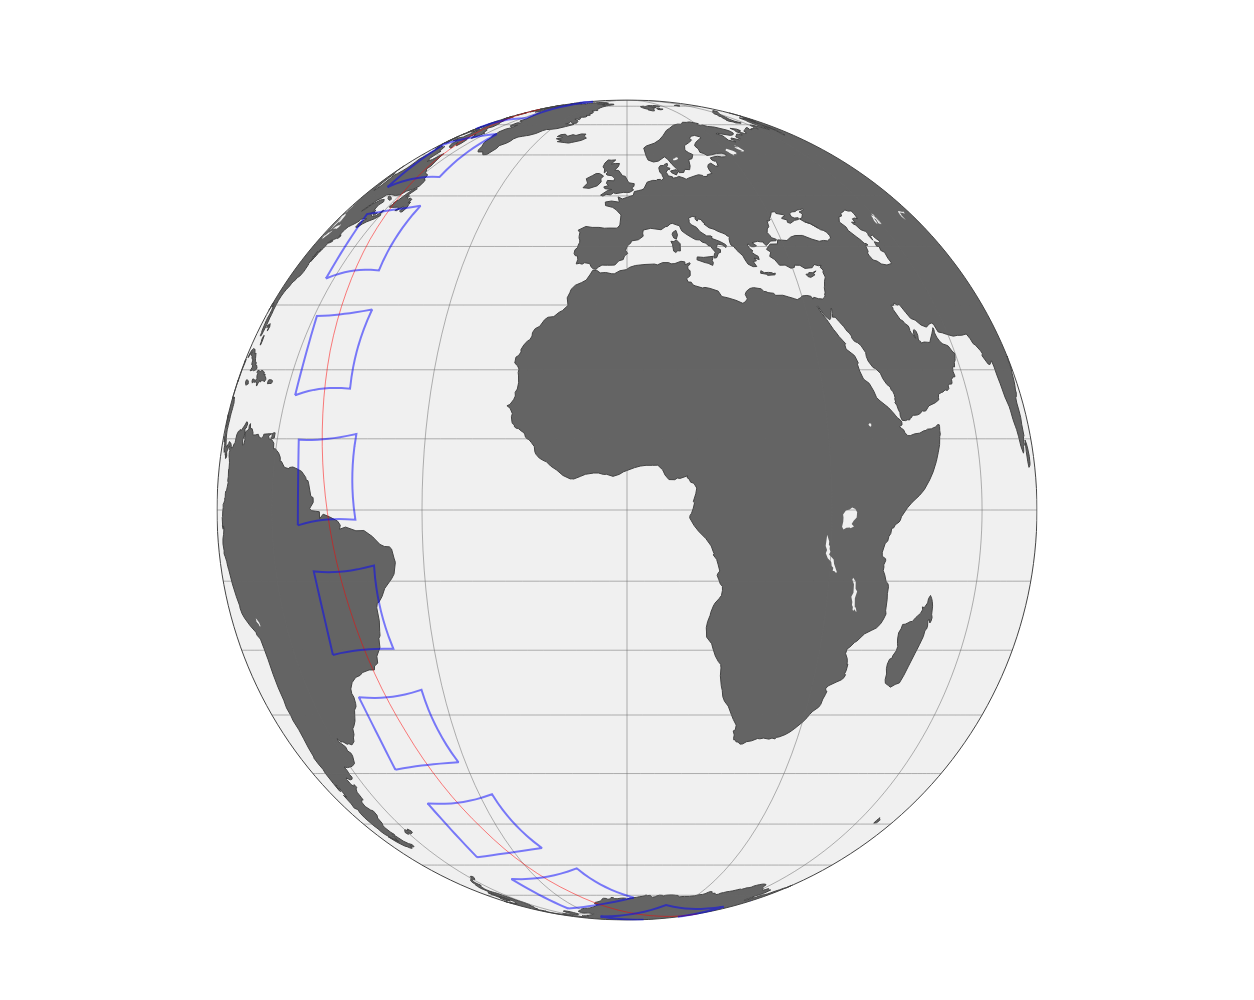

In [507]:
data = []

data.append( dict(
    type = 'scattergeo',
    lon = ground_track_df['Longitude'],
    lat = ground_track_df['Latitude'],
    mode = 'lines',
    line = dict(
        width = 1,
        color = 'rgba(255, 0, 0, 0.5)',
#         dash = 'dash'
    )
) )

[data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 2,
            color = 'rgba(0, 0, 255, 0.5)',
        )
    )
) for intersection_df in intersection_dfs]

layout = dict(
        title = None,
        showlegend = False,
        height=1000,
        geo = dict(
            showland = True,
            showlakes = True,
            showcountries = False,
            showocean = True,
            countrywidth = 0.0,
            landcolor = 'rgb(100, 100, 100)',
            lakecolor = 'rgb(240, 240, 240)',
            oceancolor = 'rgb(240, 240, 240)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(
                    lon = 0,
                    lat = 0,
                    roll = 0
                )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )
    
fig = dict(data=data, layout=layout)

iplot(fig)

In [508]:
# pio.write_image(fig, 'out.svg')

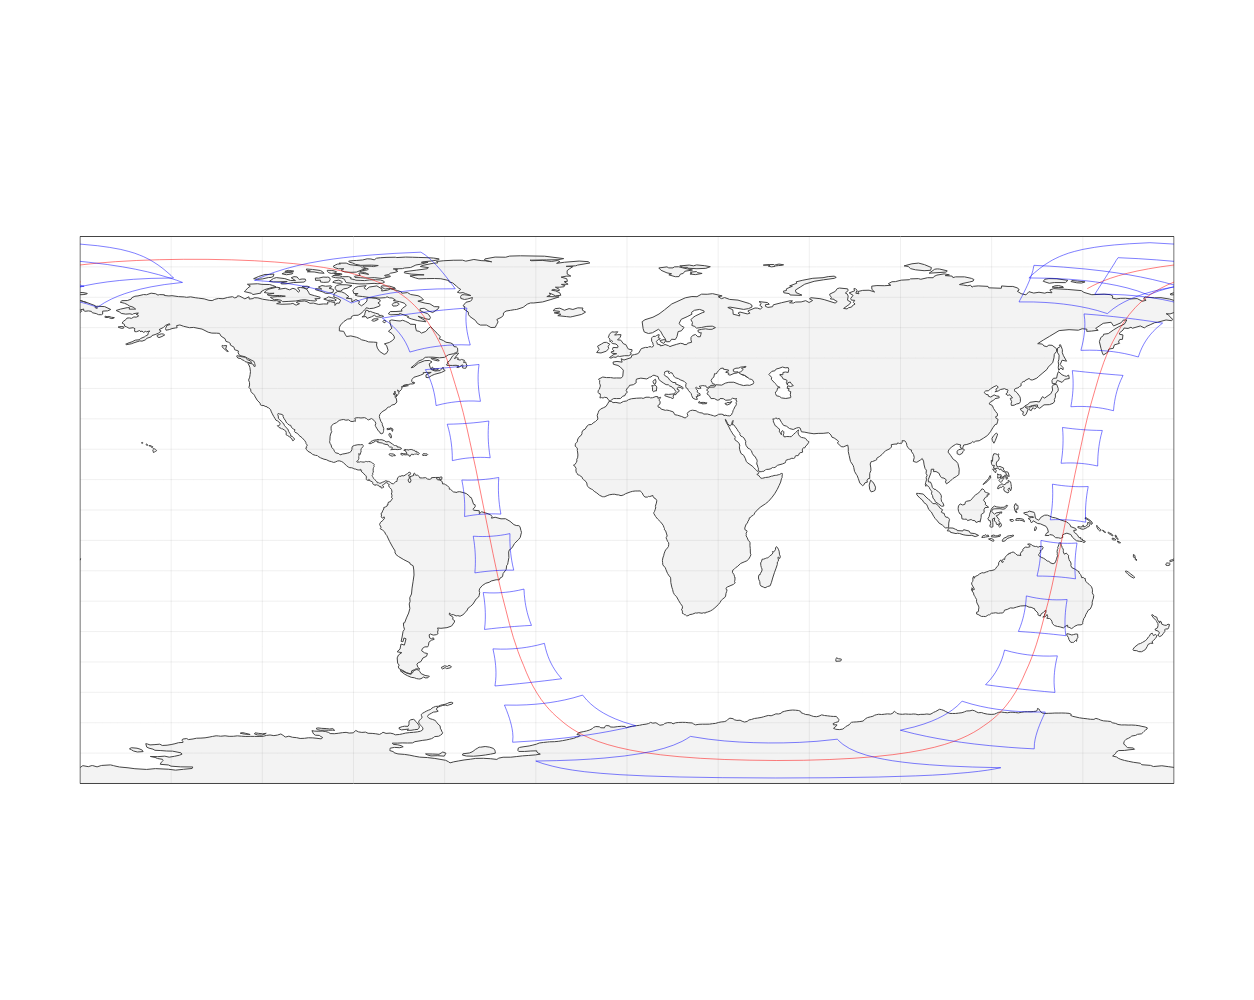

In [509]:
data = []

data.append(
    dict(
        type = 'scattergeo',
        lon = ground_track_df['Longitude'],
        lat = ground_track_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'rgba(255, 0, 0, 0.5)',
        )
    )
)

[data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'rgba(0, 0, 255, 0.5)',
        )
    )
) for intersection_df in intersection_dfs]
    
layout = dict(
        title = None,
        showlegend = False,
        height=1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.1
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.1
            )
        ),
    )
    
fig = dict(data=data, layout=layout)
iplot(fig)

---

In [510]:
raise

RuntimeError: No active exception to reraise

In [ ]:
def earth_data ():
    
    theta = np.linspace(0, 2 * np.pi, 30)
    phi = np.linspace(0, np.pi, 30)

    theta_grid, phi_grid = np.meshgrid(theta, phi)

    r = float(Physics.Environment.Objects.CelestialBodies.Earth.EquatorialRadius.inMeters())

    x = r * np.cos(theta_grid) * np.sin(phi_grid)
    y = r * np.sin(theta_grid) * np.sin(phi_grid)
    z = r * np.cos(phi_grid)

    earth = go.Surface(
        x=x,
        y=y,
        z=z,
        colorscale='Viridis',
        showscale=False
    )
    
    return earth

In [ ]:
def orbit_data (states):
    
    states_GCRF = [state.inFrame(Frame.GCRF()).getPosition().getCoordinates() for state in states]

    trace = go.Scatter3d(
        x=[state_GCRF[0][0] for state_GCRF in states_GCRF],
        y=[state_GCRF[1][0] for state_GCRF in states_GCRF],
        z=[state_GCRF[2][0] for state_GCRF in states_GCRF],
        mode='lines',
        marker=dict(
            size=0,
    #         color=orbit_df['$x_{z}^{ECI}$'],
    #         colorscale='Viridis',
            showscale=False
        ),
        line=dict(
    #         color=orbit_df['$x_{z}^{ECI}$'],
            width=1
        )
    )
    
    return trace

In [ ]:
def frame_data (frame, instants, scale):
    
    frame_origins_GCRF = [np.transpose(frame.getOriginIn(Frame.GCRF(), instant).getCoordinates())[0] for instant in instants]
    frame_axess_GCRF = [frame.getAxesIn(Frame.GCRF(), instant) for instant in instants]
    
    def axis_data (origin, axis, color):
    
        data = go.Scatter3d( x = [origin[0], origin[0] + scale * axis[0]],
                             y = [origin[1], origin[1] + scale * axis[1]],
                             z = [origin[2], origin[2] + scale * axis[2]],
                             marker = dict(
                                 size = 1
                             ),
                             line = dict(
                                 color = color,
                                 width = 6
                             )
                         )
        
        return data
    
    data = []
    
    for [frame_origin_GCRF, frame_axes_GCRF] in zip(frame_origins_GCRF, frame_axess_GCRF):
        
        data.append(axis_data(frame_origin_GCRF, np.transpose(frame_axes_GCRF.x())[0], "red"))
        data.append(axis_data(frame_origin_GCRF, np.transpose(frame_axes_GCRF.y())[0], "blue"))
        data.append(axis_data(frame_origin_GCRF, np.transpose(frame_axes_GCRF.z())[0], "green"))
    
    return data

In [ ]:
data = [earth_data(), orbit_data(states), *frame_data(body_frame, instants, scale=500000)]

layout = go.Layout(
    title=None,
#     width=800,
#     height=1000,
#     autosize=False,
    showlegend=False,
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'manual'
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig)